In [1]:
import numpy as np
from math import log, factorial
import matplotlib.pyplot as plt

In [2]:
class QueueSystem:

    def __init__(self, lambd_param=60, mu_param=2, nu_param=4, n_param=20, m_param=5):
        self.lambd = lambd_param
        self.nu = nu_param
        self.n = n_param
        self.m = m_param
        self.mu = mu_param

        self.time = 0
        self.state = 0
        self.enqueues = []
        self.dequeues = []
        self.refusal_count = 0
        self.forward_count = 0
        self.backward_count = 0
        self.forward_times = [0]
        self.backward_times = [0]
        self.ro = self.lambd / self.mu
        self.state = 0

    def get_random(self):
        return np.random.uniform(0, 1)


    def get_refusal_prob(self, state):
        if state > self.n:
            return ((state - self.n) * self.nu) / (state * self.mu + (state - self.n) * self.nu)
        else:
            return 0


    def get_backward_intensity(self, state):
        if state == 0:
            return 0
        if state <= self.n:
            return state * self.mu
        else:
            return self.n * self.mu + (state - self.n) * self.nu


    def get_forward_intensity(self, state):
        if state == self.n + self.m:
            return self.lambd
            # return 0
        return self.lambd


    def get_time_interval(self, intensity):
        if intensity != 0:
            return -1 / intensity * log(self.get_random())
        return np.inf


    def iterate(self, state):
        t_back = self.get_time_interval(self.get_backward_intensity(state))
        t_for = self.get_time_interval(self.get_forward_intensity(state))
        if t_back <= t_for:
            state -= 1
            self.backward_count += 1
            self.time += t_back
            self.dequeues.append(self.time)
            return state
        else:
            self.time += t_for
            self.forward_count += 1
            if state < self.n + self.m:
                state += 1
                self.enqueues.append(self.time)
            else:
                self.refusal_count += 1
            return state

    def part_prod(self, i):
      return np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)])

    def get_final_probs(self):
        part_sum_1 = sum([self.ro ** (i + 1) / factorial(i + 1) for i in range(self.n)])
        part_sum_2 = sum([self.ro ** (i + 1) / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)]) for i in range(self.m)])
        p0 = 1 / (1 + part_sum_1 + self.ro ** self.n / factorial(self.n) * part_sum_2)
        return [p0] + [p0 * self.ro ** (i + 1) / factorial(i + 1) for i in range(self.n)] + \
        [p0 * self.ro ** self.n / factorial(self.n) * self.ro ** (i + 1) / self.part_prod(i) for i in range(self.m)]

    def get_abs_throughput(self):
        p = self.get_final_probs()
        return self.lambd * (1 - p[self.n] * self.ro ** self.m / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(self.m)]))

    def get_refusal_prob(self):
        p = self.get_final_probs()
        print(p[self.n])
        return p[self.n] * self.ro ** self.m / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(self.m)])

    def get_avg_orders_in_QS(self):
        p = self.get_final_probs()
        return sum([(i + 1) * p[i + 1] for i in range(self.n)]) + sum(self.n * p[self.n + i + 1] for i in range(self.m))

    def get_avg_orders_in_queue(self):
        p = self.get_final_probs()
        return p[self.n] * sum(
            [(i + 1) * self.ro ** (i + 1) / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)]) for i in range(self.m)])

    def get_avg_time_QS(self):
        p = self.get_final_probs()
        return self.get_avg_orders_in_queue() / self.lambd +  self.get_abs_throughput() / self.lambd / self.mu

    def get_avg_time_queue(self):
        return self.get_avg_orders_in_queue() / self.lambd

    def get_avg_used_channels(self):
        return self.get_avg_orders_in_QS()

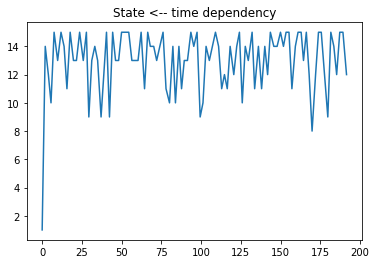

In [3]:
cur_state = 0
states = []
timestamps = []
volume = 10000
qs = QueueSystem(30, 1, 2, 5, 10)
for _ in range(volume):
    iteration = qs.iterate(cur_state)
    cur_state = iteration
    states.append(cur_state)
    timestamps.append(qs.time)

plt.plot(timestamps[::volume // 100], states[::volume // 100])
plt.title('State <-- time dependency')
plt.show()

# uniform
time_step = 0.01
time_runner = 0.0
stats = []
i = 0
while time_runner < timestamps[-1]:
        while time_runner > timestamps[i]:
            i += 1
        stats.append(states[i])
        time_runner += time_step
states = stats

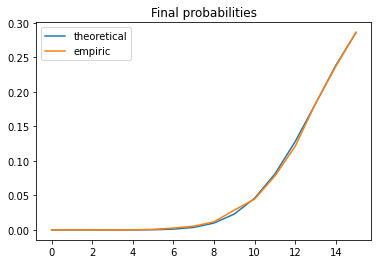

[1.2608589337494368e-09, 3.7825768012483105e-08, 5.673865201872466e-07, 5.673865201872465e-06, 4.255398901404349e-05, 0.00025532393408426096, 0.00109424543178969, 0.003647484772632299, 0.009947685743542635, 0.022956197869713774, 0.04591239573942755, 0.0810218748342839, 0.12792927605413248, 0.18275610864876068, 0.23837753302012263, 0.28605303962414713]


In [4]:
theor_final_probs = qs.get_final_probs()
emp_final_probs = [0] * len(theor_final_probs)
for state in states:
  emp_final_probs[state] += 1
emp_final_probs = np.array(emp_final_probs) / len(states)
plt.plot(list(range(qs.n + qs.m + 1)), theor_final_probs)
plt.plot(list(range(qs.n + qs.m + 1)), emp_final_probs)
plt.legend(['theoretical', 'empiric'])
plt.title('Final probabilities')
plt.show()
print(qs.get_final_probs())

In [5]:
theor_abs_throughput = qs.get_abs_throughput()
print(f'Theoretical: {theor_abs_throughput}')
emp_abs_throughput = qs.lambd * qs.backward_count / qs.forward_count
print(f'Empirical: {emp_abs_throughput}')

Theoretical: 21.418408811275583
Empirical: 21.36106831022085


In [6]:
theor_refusal_prob = qs.get_refusal_prob()
print(f'Theoretical: {theor_refusal_prob}')
emp_refusal_prob = qs.refusal_count / qs.forward_count
print(f'Empirical: {emp_refusal_prob}' )

0.00025532393408426096
Theoretical: 0.28605303962414713
Empirical: 0.28556753980482796


In [7]:
theor_avg_orders_in_QS = qs.get_avg_orders_in_QS()
print(f'Theoretical: {theor_avg_orders_in_QS}')
emp_avg_orders_in_QS = sum([state if state <= 20 else 20 for state in states]) / len(states)
print(f'Empirical: {emp_avg_orders_in_QS}')

Theoretical: 4.999944238513655
Empirical: 13.162865270235324


In [8]:
theor_avg_orders_in_queue = qs.get_avg_orders_in_queue()
print(f'Theoretical: {theor_avg_orders_in_queue}')
queue_states = []
for state in states:
  if state > 20:
    queue_states.append(state - 20)
  else:
    queue_states.append(0)
emp_avg_orders_in_queue = np.mean(queue_states)
print(f'Empirical: {emp_avg_orders_in_queue}')

Theoretical: 8.209232286380967
Empirical: 0.0


In [9]:
theor_avg_time_QS = qs.get_avg_time_QS()
print(f'Theoretical: {theor_avg_time_QS}')
emp_avg_time_QS = np.mean([qs.dequeues[i] - qs.enqueues[i] for i in range(len(qs.dequeues))])
print(f'Empirical: {emp_avg_time_QS}')

Theoretical: 0.9875880365885517
Empirical: 0.610967797349227


In [10]:
theor_avg_time_queue = qs.get_avg_time_queue()
print(f'Theoretical: {theor_avg_time_queue}')
emp_avg_time_queue = emp_avg_orders_in_queue / qs.lambd
print(f'Empirical: {emp_avg_time_queue}')

Theoretical: 0.2736410762126989
Empirical: 0.0


In [11]:
theor_avg_used_channels = qs.get_avg_used_channels()
print(f'Theoretical: {theor_avg_used_channels}')
emp_avg_used_channels = sum([state if state <= 20 else 20 for state in states]) / len(states)
print(f'Empirical: {emp_avg_used_channels}')

Theoretical: 4.999944238513655
Empirical: 13.162865270235324


In [12]:
def plot_step(lambd, mu, nu, n, m):
  cur_state = 0
  states = []
  timestamps = []
  qs = QueueSystem(lambd, mu, nu, n, m)
  while not timestamps or timestamps[-1] < 1000:
      iteration = qs.iterate(cur_state)
      cur_state = iteration
      states.append(cur_state)
      timestamps.append(qs.time)
  volume = len(timestamps)
  plt.plot(timestamps[::volume // 100], states[::volume // 100])

def plot_probs(lambd, mu, nu, n, m):
  cur_state = 0
  states = []
  timestamps = []
  volume = 1000000
  qs = QueueSystem(lambd, mu, nu, n, m)
  for _ in range(volume):
      iteration = qs.iterate(cur_state)
      cur_state = iteration
      states.append(cur_state)
      timestamps.append(qs.time)

  emp_final_probs = [0] * (qs.n + qs.m + 1)
  for state in states:
    emp_final_probs[state] += 1
  emp_final_probs = np.array(emp_final_probs) / len(states)
  plt.plot(list(range(qs.n + qs.m + 1)), emp_final_probs)

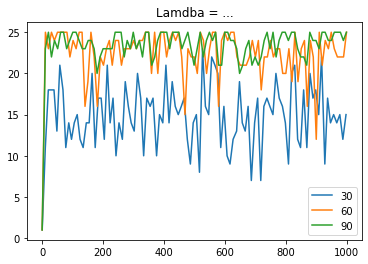

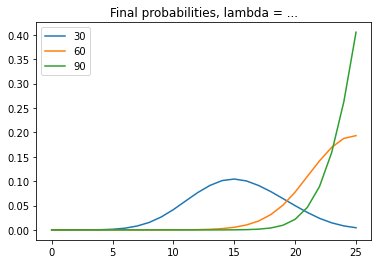

In [13]:
plot_step(30, 2, 4, 20, 5)
plot_step(60, 2, 4, 20, 5)
plot_step(90, 2, 4, 20, 5)
plt.title('Lamdba = ...')
plt.legend(['30', '60', '90'])
plt.show()

plot_probs(30, 2, 4, 20, 5)
plot_probs(60, 2, 4, 20, 5)
plot_probs(90, 2, 4, 20, 5)
plt.title('Final probabilities, lambda = ...')
plt.legend(['30', '60', '90'])
plt.show()